In [1]:
################################################################################
#   Basic configuration steps
################################################################################

#- import basic python packages
import warnings
import tkinter # to show plot in Pycharm

#- import packages for data manipulations
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE

#- import packages for unsupervised machine learning
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA, SparsePCA
from sklearn.manifold import TSNE

#- import packages for supervised machine learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE

#- import packages for model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve, roc_curve, recall_score, precision_score, average_precision_score
from sklearn.metrics import auc, roc_auc_score, classification_report

#- import packages for visualizations
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.tools import FigureFactory as FF
import plotly.io as pio
pio.renderers.default = "svg"

#- packages created
from utils import corr_heatmap, tsne_plotting, pca_plotting
from utils import model_scores, multiple_roc_curves, create_scores_df, create_prec_recall_df, precision_recall


#- configuration steps
warnings.simplefilter(action='ignore', category = FutureWarning)
palette = sns.color_palette("PiYG_r")
sns.set_palette("Set3")

In [2]:
################################################################################
#   Read CSV data file
################################################################################
'''
- all the features of the data have already been PCA-transformed except 'time' and 'amount'
- since all features need to be scaled before PCA is implemented, we can assume that all 'V' features are scaled
'''

credit_df = pd.read_csv('creditcard.csv')
print("We look at a sample of the data: \n", credit_df.head())

#- let us scale the 'time' and 'amount' features using 'RobustScaler' which is less susceptible to outliers
#- RobustScaler removes the median and scales the data according to the IQR (i.e. between 1st quartile and 3rd quartile)
robust_scaler = RobustScaler()
credit_df["robustscaled_time"] = robust_scaler.fit_transform(credit_df["Time"].values.reshape(-1,1))
credit_df["robustscaled_amount"] = robust_scaler.fit_transform(credit_df["Amount"].values.reshape(-1,1))
credit_df.head()

#- we drop some of the columns
cols_to_drop = ["Time", "Amount", "robustscaled_time"]
X = credit_df.drop(cols_to_drop + ["Class"], axis = 1)
y = credit_df.loc[:,"Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print("Shape of the X_train dataset: ", X_train.shape)
print("Shape of the y_train dataset: ", y_train.shape)

We look at a sample of the data: 
    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010  

In [3]:
################################################################################
#   Examine balance of class in dataset
################################################################################
#- plot a simple bar graph
class_counts_df = pd.DataFrame(credit_df.Class.value_counts()).sort_values(by = "Class").reset_index(drop = True)
class_counts_df["Class_name"] = ["Minority_class","Majority_class"]
class_counts_df.columns = ["Count", "Class_name"]

#- plot the graphs
fig1 = px.bar(class_counts_df, x = "Class_name", y = "Count", color = "Class_name", width = 600)
# fig1.show()

#- do a check on the actual counts
prop_result = class_counts_df.Count.min() / class_counts_df.Count.sum()
print("Minority class proportion: " + str(prop_result) + "%")
if prop_result < 1:
    print("We are dealing with a highly unbalanced dataset")
else:
    print("The dataset is not highly unbalanced")

Minority class proportion: 0.001727485630620034%
We are dealing with a highly unbalanced dataset


In [4]:
################################################################################
#   apply SMOTE technique to over-sample the minority class
################################################################################

#=== NOTE1: we apply SMOTE first, then apply train_test_split; apply SMOTE on training data only
#=== NOTE2: we apply SMOTE first, then execute cross-validation later

#- we have an unbalanced training dataset
print("Before OverSampling, counts of label 'Minority class' in training dataset: {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label 'Majority class' in training dataset: {} \n".format(sum(y_train == 0)))


#- we now implement the SMOTE technique
#- note that we need to ensure that "y_train" is continuous; so we use the "ravel" method to do that
smote = SMOTE(random_state = 88)
X_train_oversample, y_train_oversample = smote.fit_resample(X_train, y_train.ravel())

#- we now have a balanced training dataset
print("After OverSampling, counts of label 'Minority class' in training dataset: {}".format(sum(y_train_oversample == 1)))
print("After OverSampling, counts of label 'Majority class' in training dataset: {} \n".format(sum(y_train_oversample == 0)))

Before OverSampling, counts of label 'Minority class' in training dataset: 391
Before OverSampling, counts of label 'Majority class' in training dataset: 227454 

After OverSampling, counts of label 'Minority class' in training dataset: 227454
After OverSampling, counts of label 'Majority class' in training dataset: 227454 



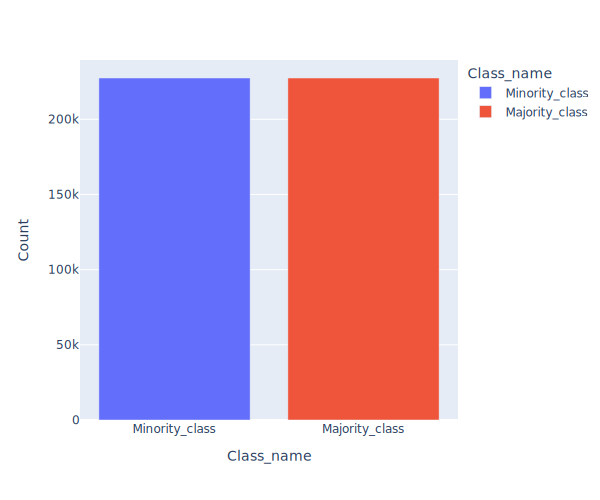

In [5]:
#- we check out the new counts plot
y_train_oversample_df = pd.DataFrame(pd.DataFrame(y_train_oversample).value_counts()).reset_index(drop = True).sort_values(by = 0)
y_train_oversample_df["Class_name"] = ["Minority_class","Majority_class"]
y_train_oversample_df.columns = ["Count", "Class_name"]

#- plot the graphs
fig2 = px.bar(y_train_oversample_df, x="Class_name", y="Count", color = "Class_name", width = 600)
fig2.show()

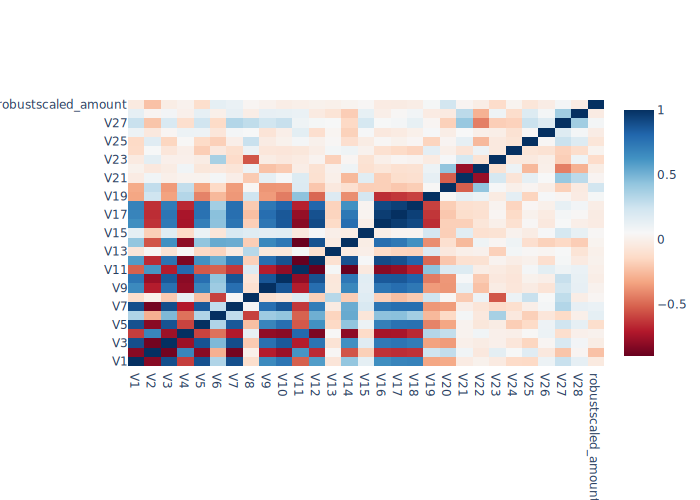

In [6]:
#- plot correlation plots on the oversampled training data
corr_heatmap(X_train_oversample)

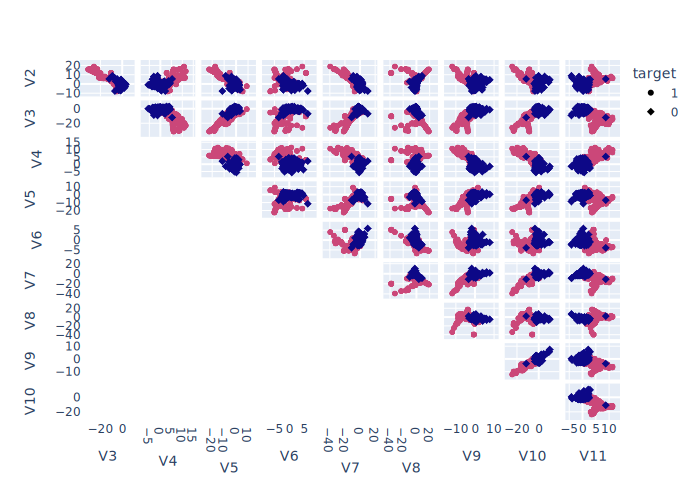

In [7]:
###############################################################################################
#   Unsupervised machine learning / clustering --- employ clustering methods: KMeans, DBSCAN
###############################################################################################

#=== we plot the scatter plot and look at the interaction of the features (subset of data shown)

#- select random four groups of 1000 samples to do clustering
y_df = pd.DataFrame(y_train_oversample).rename({0: 'target'}, axis = 1)
X_df = pd.DataFrame(X_train_oversample)

#- sample group 1
y_sample1 = y_df.sample(n = 1000, random_state = 0)
X_sample1 = X_df.iloc[y_sample1.index]
sample_df = pd.concat([X_sample1, y_sample1], axis = 1) # a well-balanced sample data

#- we plot the scatter plot matrix for selected features; we see pretty good separation of values
fig4 = px.scatter_matrix(sample_df,
                         dimensions=list(sample_df.iloc[:, 1:11].columns),
                         color="target", symbol="target")

fig4.update_traces(diagonal_visible = False)
fig4.update_traces(showlowerhalf = False)
fig4.update_coloraxes(showscale = False)
fig4.show()

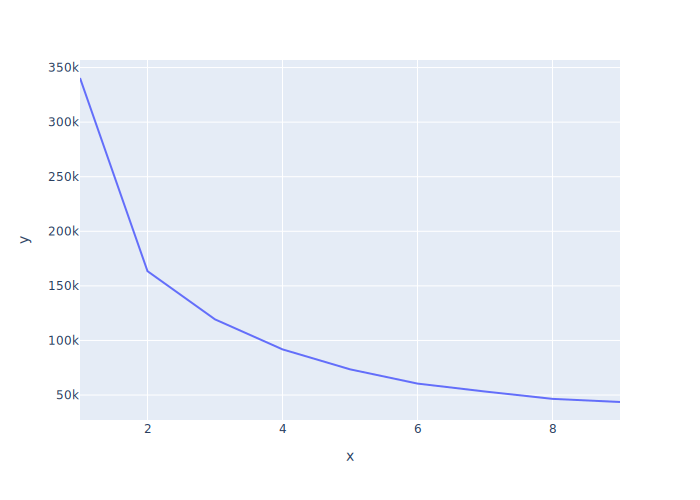

In [8]:
#=== we use different clustering to determine the clusters (KMeans, DBSCAN)

#--- we try using KMeans clustering
'''
- k-means++ is a smart centroid initialization technique algo for choosing seeds for k-means clustering algorithm
- KMeans takes exponential time to solve and hence suffers from the curse of dimensionality
- KMeans also does not handle highly imbalanced data well; fair poorly at identifying structure in small minority class
- Majority class will form large clusters and will skew all centroids nearer to it
'''

seed = 0
wcss = []
cluster_range = range(1,10)
for i in cluster_range:
    kmeans1 = KMeans(n_clusters = i, init = 'k-means++', random_state = seed)
    kmeans1.fit(sample_df)  # we fit a sample subset, oversampled data
    wcss.append(kmeans1.inertia_)

kmeans_df = pd.DataFrame({'x':list(cluster_range), 'y':wcss})

fig5 = px.line(kmeans_df, x = 'x', y = 'y')
fig5.show()  # using elbow method we see that the optimal number of cluster is 4 (using oversampled data)


#--- fit and transform based on the cluster number and create dataframe with clusterID results
kmeans_mb = MiniBatchKMeans(n_clusters = 4, random_state = seed).fit(sample_df)
X_clusters_kmeans = kmeans_mb.predict(sample_df)  # do a prediction using oversampled data
sample_cluster_kmeans_df = sample_df.copy()
sample_cluster_kmeans_df["ClustID"] = list(X_clusters_kmeans)

In [9]:
#--- we try using DBSCAN (Density-Based Spatial Clustering of Applications with Noise) clustering
'''
- DBSCAN: distance between nearest points; a Density-Based clustering algorithm
- reduces the problem of KMeans where a slight change in data points might affect the clustering outcome
- Kmeans cannot handle "odd-shaped data", and the number of clusters need to be specified (hard to know what "k" to use)
- DBSCAN: number of clusters need not be specified; all we need is a function to calculate distance between values
- and some guidance for what amount of distance is considered "close"
- DBSCAN: produces more reasonable results than KMeans across a variety of different distributions
- DBSCAN parames: (1) "minPts" (min no. of points clustered for a region to be taken as dense; at least 3 / 2 x dim)
                  (2) "eps" (a distance measure used to locate the points in the neighbourhood of any point)

- noisy samples are given the label "-1"
- DBSCAN does not seem to work well in cases where the points are mostly individually far apart from each other (hence 
- eps cannot be maintained at small values) such that we either end up having many clusters, or a lot of noisy samples)
'''
X_clusters_dbscan = DBSCAN(eps = 0.3, min_samples = 3).fit_predict(sample_df) # we are taking an unusually large eps
# print(set(X_clusters_dbscan)) # "min_samples" of 3 returns 3 clusters; anything more returns 1 cluster with noise
sample_cluster_dbscan_df = sample_df.copy()
sample_cluster_dbscan_df["ClustID"] = list(X_clusters_dbscan)
print(sample_cluster_dbscan_df.ClustID.value_counts())

-1    980
 0     10
 1      4
 3      3
 2      3
Name: ClustID, dtype: int64


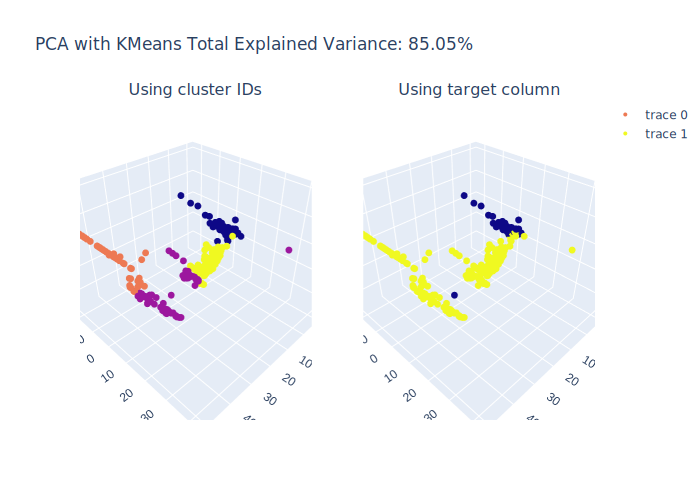

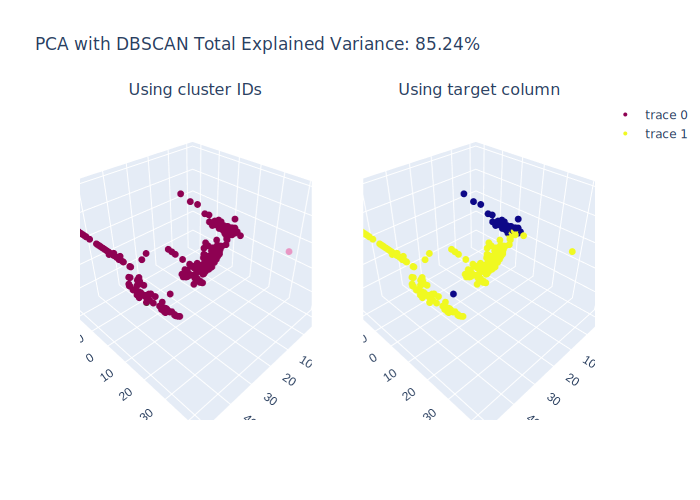

In [10]:
#=== we use the different dimensionality reduction algorithms and see how the separation of clusters is like
#--- Using Principle Component Analysis ("PCA") clustering
#--- plot the scatter plot of the result (colouring the "dots" by clusterID) using PCA
'''
- since the data itself has already been processed by PCA, the explained variance amongst all the
- features are quite distributed. And also, since we want to do viz, we take "n_components" to be 3
- for future application, we can create a new dataframe to add in the values of the PCA components
- to determine the clusters of new data, we just need to fit and transform the data into PCA components
- then determine the cluster number
'''
pca_plotting(sample_cluster_kmeans_df, "ClustID", "KMeans")
pca_plotting(sample_cluster_dbscan_df, "ClustID", "DBSCAN")

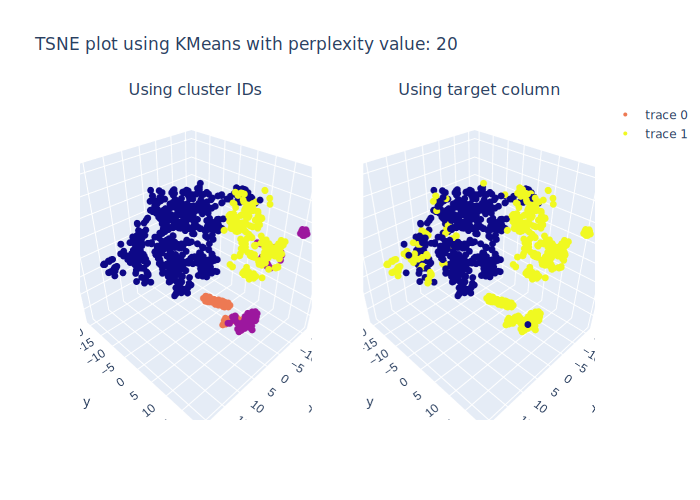

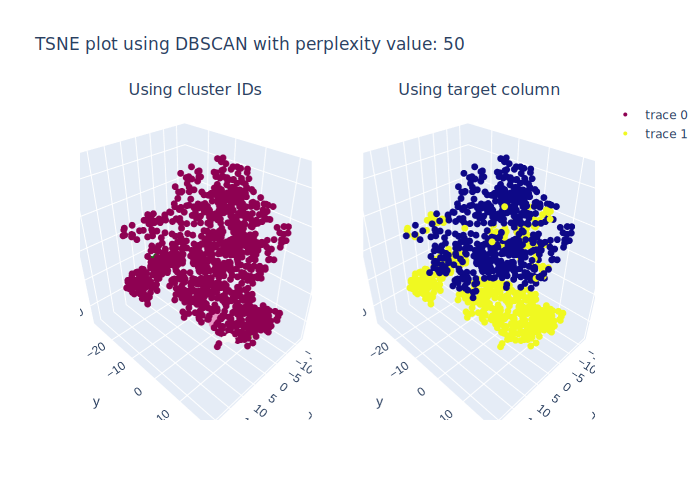

In [11]:

#=== we perform t-Distributed Stochastic Neighbour Embedding ("t-SNE") clustering
'''
- t-SNE is a tool to visualize high-dimensional data
- converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence
- between joint probabilities of the low-dimensional embedding and the high-dimensional data
- it is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or 
- TruncatedSVD for sparse data) to reduce dimensionality to a reasonable amount (e.g. 50) if the number of features is very
- high; in order to suppress some noise and speed up the computation of pairwise distances between samples 
'''
# tsne_plotting(sample_cluster_kmeans_df, "ClustID", 13, "KMeans")
tsne_plotting(sample_cluster_kmeans_df, "ClustID", 20, "KMeans")
tsne_plotting(sample_cluster_dbscan_df, "ClustID", 50, "DBSCAN")

In [12]:
########################################################################################################################
#   Supervised machine learning --- techniques employed:
#   1. Regression: Logistic Regression
#   2. Bagging / ensemble method: Random Forest Classifier
#   3. Boosting method: LightGBM
#   4. Neural Networks
########################################################################################################################

#=== Logistic Regression (with grid search cross-validation)
'''
- a Machine Learning classification algo that is used to predict the probability of a categorical dependent variable
- the dependent variable is a binary variable that contains data coded as "1" or "0"
- 'GridSearchCV' implements a 'fit' and 'score' method (also implements: 'predict', 'predict_proba'
- parameters of the estimator are optimized by cross-validated grid-search over a parameter grid
'''
#- run a grid search for the best parameter
# logreg = LogisticRegression()
# logreg_params = {'C' : [2.5, 3, 3.5, 4, 4.5], 'max_iter' : [200]}
# logreg_clf = GridSearchCV(estimator = logreg, param_grid = logreg_params, cv = 5, verbose = 5, n_jobs = 3)
# logreg_clf.fit(X_train_oversample, y_train_oversample)
# chosen_logreg_param = logreg_clf.best_params_['C']

#- use the best parameter to call the logistic regression model
logreg_best_clf = LogisticRegression(C = 3, max_iter = 200)\
                                    .fit(X_train_oversample, y_train_oversample)

logreg_pred, logreg_pred_proba, fpr_logreg, tpr_logreg, prec_logreg, recall_logreg, avg_prec_logreg = \
                                                                        model_scores(logreg_best_clf, X_test, y_test)

In [ ]:
#=== Random Forest (with grid search cross-validation)

#- run a grid search for the best parameter
'''
- Random Forest is less affected by noise and generalizes better, reducing variance (generalization error reaches a 
- limit with an increasing number of trees being grown (based on Central Limit Theorem)
- Random Forest is immune against over-fitting (as number of trees increases) as long as its weak classifiers do not 
- over-fit to data
- Parameters to tune:
    1. n_estimators: number of trees in the forest
    2. max_features: max number of features considered for splitting a node
    3. max_depth: max number of levels in each decision tree
    4. min_samples_split: min number of data points placed in a node before the node is split
'''
# rf = RandomForestClassifier()
# rf_params = {'n_estimators' : [150, 200], 'max_depth' : [10, 20], 'min_samples_split' : [5]}
# rf_clf = GridSearchCV(estimator = rf, param_grid = rf_params, cv = 5, verbose = 5, n_jobs = 3)
# rf_clf.fit(X_train_oversample, y_train_oversample)
# chosen_rf_param = rf_clf.best_params_

#- use the best parameter to call the random forest model (optimal n_estimators is 200)
rf_best_clf = RandomForestClassifier(n_estimators = 80, max_depth = 20, min_samples_split = 5)\
                                    .fit(X_train_oversample, y_train_oversample)

rf_pred, rf_pred_proba, fpr_rf, tpr_rf, prec_rf, recall_rf, avg_prec_rf = model_scores(rf_best_clf, X_test, y_test)

In [ ]:
#=== LightGBM (with grid search cross-validation)

#- run a grid search for the best parameter
'''
- Gradient boosting is a machine learning technique that produces a prediction model in the form of an ensemble of 
- weak classifiers, optimizing a differentiable loss function
- Boosted Decision Trees is a popular type of gradient boosting that is internally made of ensemble of weak decision trees
- Two different strategies to compute trees:
    1. level-wise / depth-wise: tree grows level by level, each node splits the data prioritizing nodes closer to tree root
    2. leaf-wise: tree grows by splitting the data at the nodes with the highest loss change; tends to over-fit for
                  small datasets but excels in large datasets
                   
- LightGBM uses the leaf-wise (best-first) tree growth algorithm as compared with depth-wise tree growth
- Leaf-wise algorithm can converge much faster, but prone to over-fitting if not used with the appropriate parameters
- 
- A leaf-wise tree is typically much deeper than a depth-wise tree
- LightGBM has lower training time than XGBoost and XGBoost hist 
- To get good results using a leaf-wise tree, the following are some important parameters:
    1. num_leaves: main parameter to control the complexity of the tree model; set it < 2^(max_depth)
    2. max_depth: to limit the tree depth explicitly
    3. min_data_in_leaf: important parameter to prevent over-fitting in a leaf-wise tree. Its optimal value depends on
       the number of training samples and num_leaves; setting it to a large value can avoid growing too deep a tree but
       may cause under-fitting. In practice, setting it to 100s or 1000s is enough for a large dataset

- To speed up training (may hurt training accuracy), decrease max_depth and/or decrease num_leaves, and/or 
  increase min_gain_to_split, and/or increase min_data_in_leaf / min_sum_hessian_in_leaf 
'''
# lgbm = LGBMClassifier()
# lgbm_params = {'max_depth' : [7, 8], 'num_leaves' : [2**7 - 1, 2**8 - 1], 'min_data_in_leaf' : [80, 100]}
# lgbm_clf = GridSearchCV(estimator = lgbm, param_grid = lgbm_params, cv = 5, verbose = 5, n_jobs = 3)
# lgbm_clf.fit(X_train_oversample, y_train_oversample)
# chosen_lgbm_param = lgbm_clf.best_params_

#- use the best parameter to call the random forest model
lgbm_best_clf = LGBMClassifier(max_depth = 8, min_data_in_leaf = 80, num_leaves = 2**7 - 1)\
                                    .fit(X_train_oversample, y_train_oversample)

lgbm_pred, lgbm_pred_proba, fpr_lgbm, tpr_lgbm, prec_lgbm, recall_lgbm, avg_prec_lgbm = \
                                                                            model_scores(lgbm_best_clf, X_test, y_test)

In [ ]:
###############################################################################################
#   Model evaluation of the supervised machine learning algorithms
###############################################################################################

#=== we try to evaluate the supervised machine learning models using ROC and AUC

#- create data frame with the accuracy scores
fpr_tpr_df = pd.concat([create_scores_df(fpr_logreg, tpr_logreg, "Logistic Regression"),
                        create_scores_df(fpr_rf, tpr_rf, "Random Forest Classifier"),
                        create_scores_df(fpr_lgbm, tpr_lgbm, "Light GBM Classifier")])

#- plot the curve for multiple ROC curves
multiple_roc_curves(fpr_tpr_df)

In [ ]:
#=== we try to evaluate the supervised machine learning models using precision vs recall
prec_recall_df = pd.concat([create_prec_recall_df(prec_logreg, recall_logreg, "Logistic Regression"),
                            create_prec_recall_df(prec_rf, recall_rf, "Random Forest Classifier"),
                            create_prec_recall_df(prec_lgbm, recall_lgbm, "Light GBM Classifier")])

avg_prec_dict = {"Logistic Regression" : avg_prec_logreg,
                 "Random Forest Classifier" : avg_prec_rf,
                 "Light GBM Classifier" : avg_prec_lgbm}

#- plot the precision-recall curve
precision_recall(prec_recall_df, avg_prec_dict)